In [1]:
!hostname

tc007


In [1]:
import xyz2graph
from xyz2graph import MolGraph
import numpy as np
import networkx as nx
import rdkit
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, DataStructs

import dscribe
from dscribe.descriptors import SOAP, CoulombMatrix, ACSF, MBTR
import ase
from ase.io import read
from scipy.spatial.distance import cdist, pdist, squareform
from vendi_score import vendi
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Assume soap_descriptors is an (N, D) NumPy array
def rbf_similarity_matrix(soap_descriptors, gamma):
    N = soap_descriptors.shape[0]
    # Compute squared Euclidean distance matrix
    diff = soap_descriptors[:, np.newaxis, :] - soap_descriptors[np.newaxis, :, :]
    dist_sq = np.sum(diff**2, axis=2)
    # Apply RBF kernel
    K = np.exp(-gamma * dist_sq)
    return K

In [3]:
file = ase.io.read('training-set-300.extxyz', index=':')

# soap_desc = SOAP(species=["Si", "C"], r_cut=6, n_max=8, l_max=6, periodic=True)
# soap_all = np.vstack([soap_desc.create(file[index]) for index, value in enumerate(file)])

# acsf_desc = ACSF(species=["Si", "C"], r_cut=6.0, periodic=True)
# acsf_all = np.vstack([acsf_desc.create(file[index], centers=[0]) for index, value in enumerate(file)])

mbtr_desc = MBTR(
    species=["Si", "C"],
    geometry={"function": "inverse_distance"},
    grid={"min": 0, "max": 1, "n": 100, "sigma": 0.1},
    weighting={"function": "exp", "scale": 0.5, "threshold": 1e-3},
    periodic=True,
    normalization="l2",
)

mbtr_all = np.vstack([mbtr_desc.create(file[index]) for index, value in enumerate(file)])

gamma = 50000
mbtr_sim = rbf_similarity_matrix(mbtr_all, gamma)

vendi.score_K(mbtr_sim)


# soap_sim = rbf_similarity_matrix(soap_all, 0.01)
# euclidean_matrix = cdist(soap_all, soap_all, metric='euclidean')
# cosine_similarity_matrix = 1 - cdist(soap_all, soap_all, metric='cosine')


# soap1 = soap_desc.create(file[0], centers=[0])
# soap2 = soap_desc.create(file[1], centers=[0])
# soap500 = soap_desc.create(file[150], centers=[0])

/home/cganley2/.conda/envs/ds/lib/python3.11/site-packages/dscribe/core/system.py:90: FutureWarning: Please use atoms.calc
  calculator=atoms.get_calculator(),


3.2021289928561876

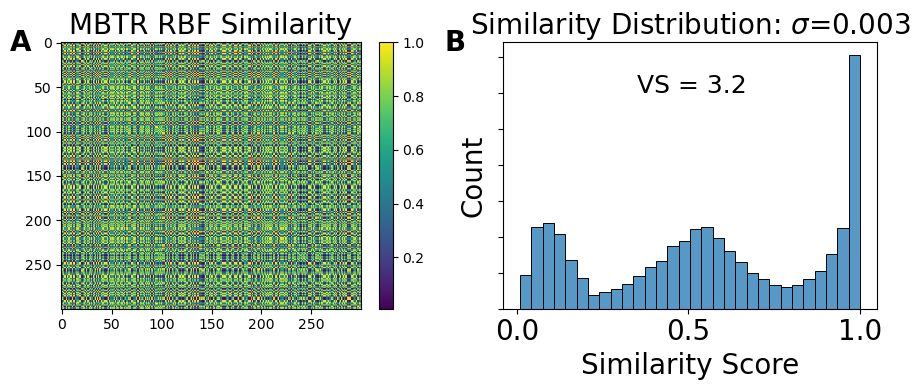

NameError: name 'pickle' is not defined

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))  # 2 rows, 1 column layout

# Plot heatmap for mbtr_sim
im1 = ax1.imshow(mbtr_sim, cmap='viridis', aspect='auto')
ax1.set_title('MBTR RBF Similarity', fontsize=20)
plt.colorbar(im1, ax=ax1)

# Add label "A" to top-left corner of ax1
ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

values = mbtr_sim[np.triu_indices_from(mbtr_sim, k=1)]
sns.histplot(values, bins=30, kde=False) # Histogram with density
ax2.set_xlabel('Similarity Score', fontsize=20)
ax2.set_title(r'Similarity Distribution: $\sigma$=0.003', fontsize=20)
ax2.set_yticklabels([])
ax2.set_ylabel('Count', fontsize=20)
ax2.text(0.35, 6000, 'VS = 3.2', fontsize=18)
ax2.tick_params(axis='x', labelsize=20)


ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

# fig.suptitle('RBF Similarity between AIMD Frames', fontsize=16)

plt.tight_layout()
plt.show()
fig.savefig('MBTR-RBF-300.png', dpi=600, bbox_inches='tight')

with open('MBTR-RBF-300.pkl', 'wb') as f:
    pickle.dump(fig, f)

In [89]:
pairs_with_scores = np.array([(i, j, mbtr_sim[i, j]) for i in range(mbtr_sim.shape[0]) for j in range(i + 1, mbtr_sim.shape[1])])
sorted_arr = pairs_with_scores[pairs_with_scores[:, 2].argsort()]
indices = sorted_arr[:, :2]
unique_values, unique_indices = np.unique(indices.flatten(), axis=0, return_index=True)
first_unique_entries = indices.flatten()[np.sort(unique_indices)].astype(int)

In [90]:
first_unique_entries

array([  3, 239,  19, 154, 215, 226, 136,  92, 249,   6, 110,  89,  45,
        62, 169, 128,  44, 267, 279, 282, 137, 295, 263,   9, 218, 223,
        35, 262, 189, 191,  12, 178, 163, 168, 174, 179, 104, 285, 121,
       151, 202, 131, 230, 205,  54, 134,  58,  70, 122, 175, 275, 144,
       148, 109, 211,  77,  13,  83, 150,  32,  48,  71, 162, 235, 199,
       127, 247,  76, 248, 187, 273, 119, 290, 161,  18,  24,   4, 264,
       188, 253, 113, 291, 133, 107,  43,  37, 118, 207,  27,  40, 195,
       164, 214, 173,  10, 284,  26, 142, 277,  78,  64, 288,  75, 182,
        31, 141, 217, 192, 286,  14,  21, 257,  20, 116, 135, 256, 242,
        90, 229, 147, 130,  11, 246,  34,  47, 240, 287, 297, 115,  97,
       197, 276, 177, 138, 227,  84, 245,  29, 102,  91, 103,   0, 280,
       200, 108,  36, 196, 259, 125, 270, 140, 289, 292, 106, 236, 213,
       190,  93, 251,   1, 255,  25,  99,   5, 212, 158, 132, 231,  16,
       171,  38, 181, 180, 126,  46, 157, 269, 105, 296, 152,  6

In [91]:
import pickle
with open('MBTR-RBF-300.pkl', 'wb') as f:
    pickle.dump(first_unique_entries, f)

In [106]:
training050 = [file[index] for index in first_unique_entries[:50]]
training100 = [file[index] for index in first_unique_entries[:100]]
training150 = [file[index] for index in first_unique_entries[:150]]
training200 = [file[index] for index in first_unique_entries[:200]]
training250 = [file[index] for index in first_unique_entries[:250]]
training300 = [file[index] for index in first_unique_entries[:300]]

ase.io.write('training050-rbf.extxyz', images=training050)
ase.io.write('training100-rbf.extxyz', images=training100)
ase.io.write('training150-rbf.extxyz', images=training150)
ase.io.write('training200-rbf.extxyz', images=training200)
ase.io.write('training250-rbf.extxyz', images=training250)
ase.io.write('training300-rbf.extxyz', images=training300)

ase.io.write('training050-ran.extxyz', images=file[:50])
ase.io.write('training100-ran.extxyz', images=file[:100])
ase.io.write('training150-ran.extxyz', images=file[:150])
ase.io.write('training200-ran.extxyz', images=file[:200])
ase.io.write('training250-ran.extxyz', images=file[:250])
ase.io.write('training300-ran.extxyz', images=file[:300])

In [ ]:
t050 = ase.io.read('training200-rbf.extxyz', index=':')

mbtr_desc = MBTR(
    species=["Si", "C"],
    geometry={"function": "inverse_distance"},
    grid={"min": 0, "max": 1, "n": 100, "sigma": 0.1},
    weighting={"function": "exp", "scale": 0.5, "threshold": 1e-3},
    periodic=True,
    normalization="l2",
)

mbtr_all = np.vstack([mbtr_desc.create(t050[index]) for index, value in enumerate(t050)])

gamma = 50000
mbtr_sim = rbf_similarity_matrix(mbtr_all, gamma)
vendi.score_K(mbtr_sim)

In [13]:
mg1 = MolGraph()
mg1.read_xyz('singleframe.xyz')

mg2 = MolGraph()
mg2.read_xyz('singleframe2.xyz')

G1 = mg1.to_networkx()
G2 = mg2.to_networkx()

graphs = [G1, G2]

# s1 = mg1.to_smiles()
# s2 = mg2.to_smiles()

# m1 = Chem.MolFromSmiles(s1)
# m2 = Chem.MolFromSmiles(s2)

# f1 = rdMolDescriptors.GetMorganFingerprintAsBitVect(m1, 2)
# f2 = rdMolDescriptors.GetMorganFingerprintAsBitVect(m2, 2)

# sim = DataStructs.TanimotoSimilarity(f1, f2)

In [14]:
n_graphs = len(graphs)
sim_matrix = np.zeros((n_graphs, n_graphs))


ged = nx.optimize_graph_edit_distance(G1, G2)
# for i in range(n_graphs):
#     for j in range(i, n_graphs):
#         ged = nx.graph_edit_distance(graphs[i], graphs[j])
#         sim_matrix[i, j] = sim_matrix[j, i] = 1.0 / (1 + ged)

In [15]:
ged

<generator object optimize_graph_edit_distance at 0x15549f456bc0>